In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import pickle
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import transformers
from transformers import BertModel, BertConfig

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


In [2]:
class COCOImage(Dataset):
    # Returns an image and one of its caption
    # in torch tensors. Image is normalized with imagenet
    def __init__(self, image_path, index_file, tokenizer):
        super().__init__()
        self.index_file = index_file
        self.image_path = image_path
        self.image_list = list(index_file.keys())
        self.tokenizer = tokenizer
        
        self.tidy_image = transforms.Compose([
            transforms.Resize((110, 110)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 #std=[0.229, 0.224, 0.225]),
        ])
        
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, ix):
        
        image_name = self.image_list[ix]
        image_path = f'{self.image_path}{image_name}'
        image_hwc = Image.open(image_path).convert('RGB')
        #image_chw = (torch.FloatTensor(image_hwc.transpose((2, 0, 1)))
        image = self.tidy_image(image_hwc).to(device) # .transpose((2, 0, 1))
        
        # picking one of the captions for the image
        caps = self.index_file[image_name]
        caps = random.sample(caps, 1)[0]
        enc = self.tokenizer(caps, padding = True, max_length = 80,
                                     pad_to_multiple_of = 80)
        caps = torch.LongTensor(enc['input_ids']).to(device)
        ids = torch.LongTensor(enc['token_type_ids']).to(device)
        return image, caps, ids
        

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class BertEmbedding(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        
    def forward(self, x, y):
        _, bert_out = self.bert(x, y)
        bs, emb_sz = bert_out.size()
        return bert_out.detach() + 0.1 * torch.randn(bs, emb_sz, device=device) #.detach()


def t_conv_block(in_c, out_c, ks, s, pad, bias = False):
    # Transposed conv a.k.a. upsampling
    return nn.Sequential(nn.ConvTranspose2d(in_c , out_c, ks, s, 
                                            pad, bias = bias),
                         nn.BatchNorm2d(out_c),
                         nn.LeakyReLU(inplace = True, 
                                      negative_slope = 0.1))

def conv_block(in_c, out_c, ks, s, pad, bias = False):
    return nn.Sequential(nn.Conv2d(in_c, out_c, ks, s, 
                                   pad, bias = bias),
                         nn.BatchNorm2d(out_c),
                         nn.LeakyReLU(inplace = True, 
                                      negative_slope = 0.1))

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, ks, s, pad, bias = False):
        super().__init__()
        self.conv1 = conv_block(in_c, out_c, ks, s, pad, bias = False)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias = False)
        self.act = nn.LeakyReLU(inplace = True,negative_slope = 0.1)
        
    def forward(self, x):
        res = self.conv1(x)
        x = self.conv2(res)
        return self.act(x + res)
    
class TResBlock(nn.Module):
    def __init__(self, in_c, out_c, ks, s, pad, bias = False):
        super().__init__()
        self.conv1 = t_conv_block(in_c, out_c, ks, s, pad, bias = False)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias = False)
        self.act = nn.LeakyReLU(inplace = True,negative_slope = 0.1)
        
    def forward(self, x):
        res = self.conv1(x)
        x = self.conv2(res)
        return self.act(x + res)
        

class Discriminator(nn.Module):
    # Acts as gan discriminator, i.e. binary classifier that 
    # predicts {Generated Image, True Image} given images.
    # Also has a 10-class classifier that learns to recognize digits
    # in addition to {Generated Image, Legitimage Image}, can't hurt,
    # probably helps. 
    def __init__(self, nf = 16):
        super().__init__()
        layers = [ResBlock(3, nf, 4, 2, 1), # (1, 28, 28) -> (nf, 14, 14)
                  nn.Dropout2d(0.1),
                  ResBlock(nf, nf * 2, 4, 2, 1), # (nf, 14, 14) -> (nf *2, 7, 7)
                  nn.Dropout2d(0.1),
                  ResBlock(nf * 2, nf * 4, 4, 2, 1), # (nf *4, 7, 7)
                  nn.Dropout2d(0.1),
                  ResBlock(nf * 4, nf * 4, 4, 2, 1),
                  nn.Dropout2d(0.1),
                  ResBlock(nf * 4, nf * 4, 3, 1, 1),
                  #nn.Dropout2d(0.1),
                  #nn.Conv2d(nf * 4, nf * 4, 4, 2, 1),
                  nn.AdaptiveAvgPool2d(1),
                  nn.Flatten(),
                  ]
        # Conv base
        self.conv_layers = nn.Sequential(*layers)
        # Binary classifier {generated, true}
        self.disc = nn.Sequential(nn.Linear(nf * 4, 1, bias = True), 
                                   nn.Sigmoid())
        # Digit recognizer
        self.apply(weights_init)

    def forward(self, x):
        x = self.conv_layers(x)
        return self.disc(x)
    
class Generator(nn.Module):
    # Generates (1, 28, 28) images from noise vectors of size (emb_sz, 1, 1)
    # with the help of 3 deconvolution blocks and 2 conv blocks.
    #
    # Deconvolution blocks upsample the image from (emb_sz, 1, 1) to (nf, 7, 7) 
    # to (nf * 2, 14, 14) to (nf * 4, 28, 28).
    #
    # Conv blocks only play with the image's depth and are not strictly necessary.
    #
    # Contrary to vanilla GANs, the image is not generated purely from a noise vector as input.
    # Instead, inputs are learnt embeddings, to which gaussian noise is added.
    # Hopefully these embeddings can help generating digits of our choice.
    # A small digit classifier is added right after the embedding layer to enforce this effect.
    def __init__(self, emb, nf = 16, emb_sz = 768):
        super().__init__()
        self.emb = emb
        layers = [TResBlock(emb_sz, nf, 5, 1, 0),
                  TResBlock(nf, nf * 2, 4, 2, 0),
                  TResBlock(nf * 2, nf * 4, 4, 2, 0),
                  TResBlock(nf * 4, nf * 4, 4, 2, 0),
                  TResBlock(nf * 4, nf * 4, 4, 2, 0),
                  ResBlock(nf * 4, nf * 4, 3, 1, 1),
                  #TResBlock(nf * 4, nf * 4, 4, 2, 0),
                  nn.Conv2d(nf * 4, 3, kernel_size = 3, 
                            stride = 1, padding = 1, bias = True),
                  nn.Sigmoid()]
        self.layers = nn.Sequential(*layers)
        self.apply(weights_init)
        
    def forward(self, x, y):
        emb = self.emb(x, y)
        return self.layers(emb[...,None,None]) 
    


In [4]:
device = torch.device('cuda')

tokenizer = (transformers.BertTokenizer
             .from_pretrained('bert-base-uncased'))

batch_size = 32
emb_sz = 768

# importing and indexing coco dataset

data_path = '/media/dlo/New Volume/captioning_data/'
image_path = f'{data_path}train2014/'

with open(f'{data_path}index.pkl', 'rb') as f:
    index_file = pickle.load(f)

ccd = COCOImage(image_path, index_file, tokenizer)
ccd = DataLoader(ccd, batch_size = batch_size, shuffle = True)

bert_model = BertModel.from_pretrained('bert-base-uncased').to(device).eval()

num_epochs = 1

g = Generator(BertEmbedding(bert_model)).to(device)
g.load_state_dict(torch.load('gen_ovn'))
d = Discriminator().to(device)
d.load_state_dict(torch.load('disc_ovn'))


g_opt = optim.Adam(g.parameters(), lr = 2e-4)
g_sched = torch.optim.lr_scheduler.OneCycleLR(g_opt, max_lr = 2e-4, 
                                              epochs = num_epochs, 
                                              steps_per_epoch = len(ccd) - 1)

d_opt = optim.Adam(d.parameters(), lr = 2e-4)
d_sched = torch.optim.lr_scheduler.OneCycleLR(d_opt, max_lr = 2e-4, 
                                              epochs = num_epochs, 
                                              steps_per_epoch = len(ccd) - 1)

bce = nn.BCELoss()
mse = nn.MSELoss()

In [5]:
def discriminator_step(img, text, ids):
    d_opt.zero_grad()
    
    # train discriminator on real data
    d_out = d(img)
    # binary GAN loss: true data, 1's as output
    loss_real = bce(d_out, torch.ones(batch_size, 1).to(device))
    # custom digit classifier loss
    
    # train discriminator on generated data
    g_out = g(text, ids)
    d_out = d(g_out)
    # binary GAN loss: fake data, 0's as output
    loss_gen = bce(d_out, torch.zeros(batch_size, 1).to(device))

    loss = loss_real + loss_gen
    loss.backward()
    d_opt.step()
    d_sched.step()
    return loss.data.item()

def generator_step(img, text, ids):
    g_opt.zero_grad()
    
    # generating random ints to be embedded
    
    g_out = g(text, ids)
    d_out = d(g_out)
    # binary GAN loss: fake data but 1's as output as we train the generator
    # to fool the discriminator
    loss = bce(d_out, torch.ones(batch_size, 1).to(device))
    # custom digit classifier loss, directly from embeddings and from the
    # discriminator's output (not sure it's a good idea)
    loss += mse(g_out, img)
    
    loss.backward()
    g_opt.step()
    g_sched.step()
    return loss.data.item()

def train_step(img, text, ids):
    return discriminator_step(img, text, ids), generator_step(img, text, ids)

In [6]:
def plot_generated(text, ids):
    # plotting generator's output when given [0, ..., 9]
    # as input embeddings
    with torch.no_grad():
        gen = g(text, ids)
        for i in range(5):
            plt.figure()
            decoded = tokenizer.decode(text[i].cpu().numpy())
            decoded = decoded.replace('[PAD]', '')
            print(decoded)
            im = ((gen[i].squeeze(0).cpu().numpy().transpose(1,2,0)))
            #im *= [0.229, 0.224, 0.225]
            #im += [0.485, 0.456, 0.406]
            plt.imshow(im)
            plt.show()


[CLS] a desktop holding two white mice and a stack of books. [SEP]                                                                  


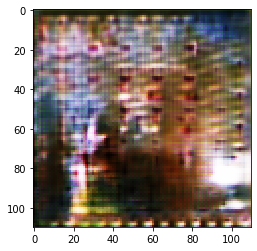

[CLS] we see a clock tower at the top of the hill. [SEP]                                                                  


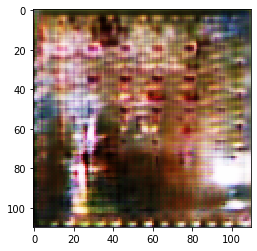

[CLS] a person riding a snow board on a snowy surface [SEP]                                                                    


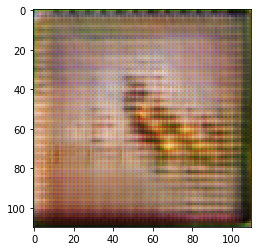

[CLS] a crowded city street at night with street lights. [SEP]                                                                    


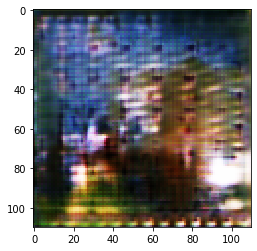

[CLS] a cat looking out a a window at a cat laying on a porch outside. [SEP]                                                              


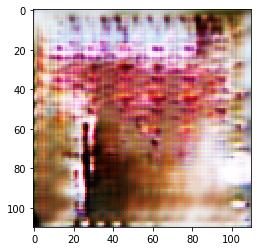

[CLS] a yellow train passing by another train next to buildings. [SEP]                                                                   


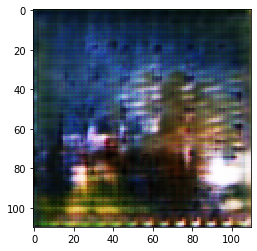

[CLS] the boy is preparing the pizza with shredded cheese and tomato sauce. [SEP]                                                                 


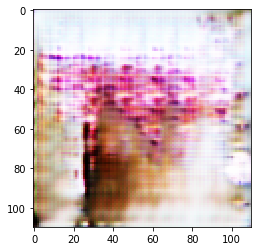

[CLS] a white toilet sitting next to a wall with a window. [SEP]                                                                  


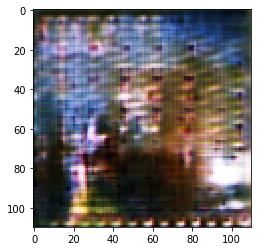

[CLS] banana slices sitting on top of some chocolate waffles [SEP]                                                                   


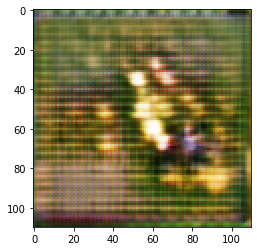

[CLS] a large long - distance bus parked by the side of a street. [SEP]                                                                


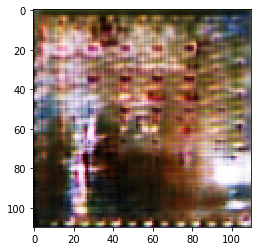

[CLS] an all white horse standing in an enclosure. [SEP]                                                                     


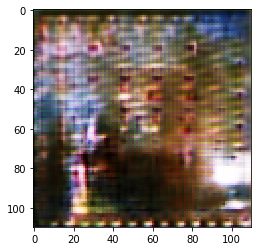

[CLS] a kitchen with a stove a microwave and a cupboard [SEP]                                                                    


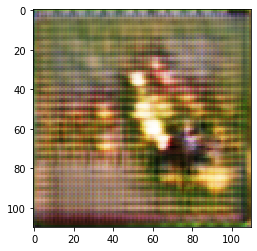

[CLS] a baseball bat with a glove and ball. [SEP]                                                                     


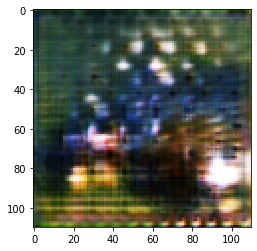

[CLS] we are looking at a plate of asian food. [SEP]                                                                    


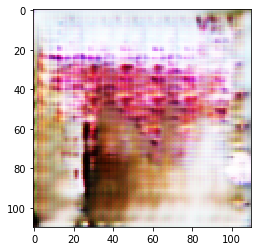

[CLS] a group of men all dressed in navy blue, with sashes and silver hoods with red peace symbols on them, take the field. [SEP]                                                  


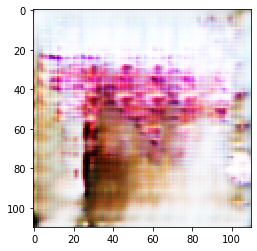

[CLS] a man on skies along a ski trail. [SEP]                                                                     


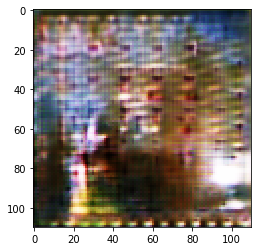

[CLS] brown dog lying on cobble road enjoying a nap. [SEP]                                                                   


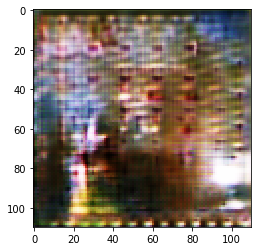

[CLS] a lone zebra standing within a wire fence. [SEP]                                                                     


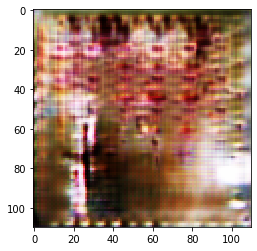

[CLS] a business man cutting a cake with a 50th sign nearby. [SEP]                                                                  


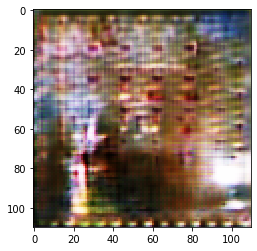

[CLS] a man riding a skateboard into the air. [SEP]                                                                    


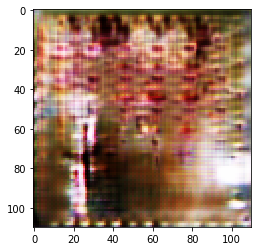

[CLS] a giraffe in a field of shrubbery and grass. [SEP]                                                                 


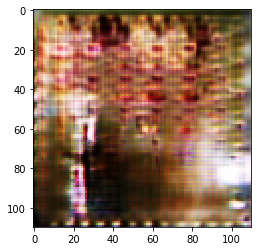

[CLS] a group of people kicking around a soccer ball. [SEP]                                                                    


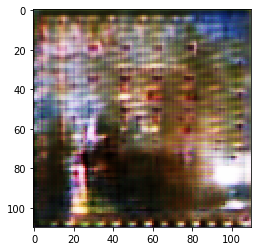

[CLS] a blender is full of red liquid on a counter. [SEP]                                                                  


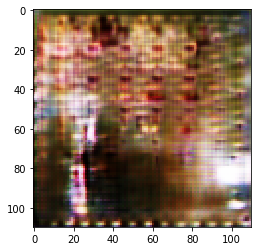

[CLS] a painting of white flowers in a vase [SEP]                                                                      


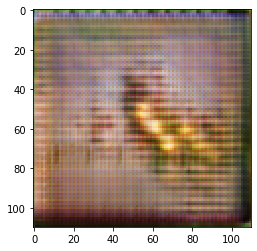

[CLS] a person hitting a tennis ball in the air with a tennis racket [SEP]                                                                


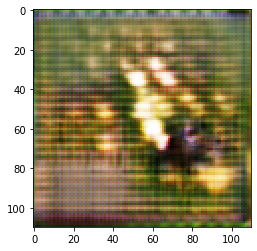

In [ ]:
for ep in range(1, num_epochs + 1):

    d_losses = []
    g_losses = []
    for ix, (img, text, ids) in enumerate(tqdm(ccd)):
        if ix % 20 == 0:
            plot_generated(text, ids)
        if img.size(0) == batch_size:
            d_loss, g_loss = train_step(img.to(device), 
                                        text.to(device),
                                        ids.to(device))
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            
    print(f"Epoch {ep}: gen loss {round(np.mean(g_losses), 2)} ")
    print(f"disc loss {round(np.mean(d_losses), 2)}")
    


In [8]:
torch.save(g.state_dict(), 'gen_ovn')

In [9]:
torch.save(d.state_dict(), 'disc_ovn')